<a href="https://colab.research.google.com/github/vishalsahuu/Book-Recommendation-System/blob/main/Book_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Project Title: Book Recommendation System**

## **Project Description**

### **Problem Statement**
---
During the last few decades, with the rise of Youtube, Amazon, Netflix, and many other such web services, recommender systems have taken more and more place in our lives. From e-commerce (suggest to buyers articles that could interest them) to online advertisement (suggest to users the right contents, matching their preferences), recommender systems are today unavoidable in our daily online journeys.

In a very general way, recommender systems are algorithms aimed at suggesting relevant items to users (items being movies to watch, text to read, products to buy, or anything else depending on industries).

Recommender systems are really critical in some industries as they can generate a huge amount of income when they are efficient or also be a way to stand out significantly from competitors. The main objective is to create a book recommendation system for users.

### **Dataset Description**
---
The Book-Crossing dataset comprises 3 files.

* **Users:** Contains the users. Note that user IDs (User-ID) have been anonymized and map to integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL values.

* **Books:** Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in the case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavors (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon website.

* **Ratings:** Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.


In [1]:
# Importing important libraries and modules

# For data reading and manipulation
import pandas as pd
import numpy as np

# For data visualization
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(8,5),'figure.dpi':100})
import seaborn as sns
import random

# This is to supress the warning messages (if any) generated in our code
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the csv datasets
df_books=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PROJECTS/Unsupervised ML/Books.csv')
df_ratings=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PROJECTS/Unsupervised ML/Ratings.csv')
df_users=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PROJECTS/Unsupervised ML/Users.csv')

In [3]:
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [4]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [5]:
df_books.describe()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271359,271360,271358,271360,271360,271357
unique,271360,242135,102023,202,16807,271044,271044,271041
top,0195153448,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/225307649X.0...
freq,1,27,632,13903,7535,2,2,2


In [6]:
df_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [7]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [8]:
df_ratings.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [9]:
df_users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [10]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


Age column has alot of missing values.

In [11]:
df_users.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


There is the high imbalance in age column having max age of 244 and minimum age of 0 which could be due to some error.

In [12]:
# Size of datasets
print(f'''\t  Size of books data is {df_books.shape}
          Size of ratings data is {df_ratings.shape}
          Size of users data is {df_users.shape}''')

	  Size of books data is (271360, 8)
          Size of ratings data is (1149780, 3)
          Size of users data is (278858, 3)


In [13]:
# Duplicates in datasets
print(f'''\t  Duplicates in books data is {df_books.duplicated().sum()}
          Duplicates in ratings data is {df_ratings.duplicated().sum()}
          Duplicates in users data is {df_users.duplicated().sum()}''')

	  Duplicates in books data is 0
          Duplicates in ratings data is 0
          Duplicates in users data is 0


## **Pre-processing and Cleaning**

In [14]:
# Merging the data frames
merged_df=pd.merge(df_users,df_ratings,on='User-ID')
merged_df=pd.merge(merged_df,df_books,on='ISBN')

In [15]:
merged_df.head()

,User-ID,Location,Age,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,2,"stockton, california, usa",18.0,0195153448,0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,8,"timmins, ontario, canada",NaN,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,11400,"ottawa, ontario, canada",49.0,0002005018,0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
3,11676,"n/a, n/a, n/a",NaN,0002005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
4,41385,"sudbury, ontario, canada",NaN,0002005018,0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


In [16]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031136 entries, 0 to 1031135
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   User-ID              1031136 non-null  int64  
 1   Location             1031136 non-null  object 
 2   Age                  753301 non-null   float64
 3   ISBN                 1031136 non-null  object 
 4   Book-Rating          1031136 non-null  int64  
 5   Book-Title           1031136 non-null  object 
 6   Book-Author          1031135 non-null  object 
 7   Year-Of-Publication  1031136 non-null  object 
 8   Publisher            1031134 non-null  object 
 9   Image-URL-S          1031136 non-null  object 
 10  Image-URL-M          1031136 non-null  object 
 11  Image-URL-L          1031132 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 102.3+ MB


In [17]:
merged_df.shape

(1031136, 12)

In [18]:
merged_df.duplicated().sum()

0

In [19]:
# Dropping last three columns containing image URLs which will not be required for the analysis
merged_df.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'],axis=1,inplace=True)

# Making column names handy to use
# Replacing '-' with '_' and column name in lower case
merged_df.columns= merged_df.columns.str.strip().str.lower().str.replace('-', '_')

# To display the entire content of a column
pd.set_option('display.max_colwidth', -1)

In [20]:
# Create a country column at the place of location 
merged_df['country'] = merged_df['location'].astype(str).apply(lambda x:x.split(',')[-1])
# Drop the location column
merged_df.drop('location',axis=1,inplace=True)

In [21]:
merged_df['country'].unique()

array([' usa', ' canada', ' n/a', '', ' malaysia', ' spain',
       ' new zealand', ' finland', ' united kingdom', ' portugal',
       ' brazil', ' germany', ' austria', ' italy', ' netherlands',
       ' australia', ' france', ' costa rica', ' poland', ' us', ' iran',
       ' aruba', ' india', ' pakistan', ' taiwan', ' singapore',
       ' argentina', ' romania', ' greece', ' ireland', ' philippines',
       ' belgium', ' philippines"', ' mexico', ' south africa',
       ' burkina faso', ' croatia', ' switzerland', ' denmark', ' rwanda',
       ' yugoslavia', ' turkey', ' china', ' japan', ' qatar', ' latvia',
       ' sweden', ' kuwait', ' indonesia', ' nepal', ' peru',
       ' venezuela', ' south korea"', ' hong kong', ' united states',
       ' slovakia', ' norway', ' dominican republic',
       ' bosnia and herzegovina', ' south korea', ' macedonia', ' kenya',
       ' mauritius', ' catalonia', ' nigeria', ' madagascar', ' israel',
       ' oman', ' egypt', ' lithuania', ' guate

In [22]:
# fix the unknown and missing values
merged_df['country'] = merged_df['country'].replace('','other').replace(' n/a','other')

In [23]:
# A function to get the missing values count and it's percentage
def missing_values(df):
  print(f'Count of missing values is \n{df.isnull().sum()}')
  print('-'*30)
  print(f'Percentage of missng values is \n{df.isnull().mean()*100}')

In [24]:
missing_values(merged_df)

Count of missing values is 
user_id                0     
age                    277835
isbn                   0     
book_rating            0     
book_title             0     
book_author            1     
year_of_publication    0     
publisher              2     
country                0     
dtype: int64
------------------------------
Percentage of missng values is 
user_id                0.000000 
age                    26.944554
isbn                   0.000000 
book_rating            0.000000 
book_title             0.000000 
book_author            0.000097 
year_of_publication    0.000000 
publisher              0.000194 
country                0.000000 
dtype: float64


In [25]:
merged_df.head()

,user_id,age,isbn,book_rating,book_title,book_author,year_of_publication,publisher,country
0,2,18.0,0195153448,0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,usa
1,8,NaN,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,canada
2,11400,49.0,0002005018,0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,canada
3,11676,NaN,0002005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,other
4,41385,NaN,0002005018,0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,canada


In [26]:
# getting unique value from 'year_of_publication' feature
merged_df['year_of_publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1987, 1989, 1992, 1983, 1979, 1995, 1982, 1985, 1986,
       1978, 1980, 1952, 1990, 1981, 0, 1984, 1968, 1961, 1959, 1946,
       1974, 1958, 1976, 1971, '2002', 1977, 1975, 1965, 1941, 1970,
       '1996', '1999', 1972, '1989', '1992', '2001', 1953, 1962, 1973,
       '2004', 1960, '1997', '2000', '0', 1954, 1966, 1920, '1998',
       '2003', 1967, 1956, 1942, 1955, 1951, 1969, 1948, '1977', '1990',
       '1986', '1994', '1982', 1963, 1964, '1995', '1959', '1988', 1950,
       '1991', '1984', 2005, 1943, '1993', '1987', '1983', '1981', 1957,
       '1972', '1980', 1937, 1940, '1965', '1970', '1979', 1930, 1923,
       1945, 1947, '1976', 1936, '1985', '1978', 1925, '1966', '1958',
       '1975', '1973', 1927, '1974', '1967', '1971', '1969', 2030, '1968',
       2011, '1960', '1964', 2020, 1939, 1926, 1938, '1961', 1911, 1904,
       1949, 1932, 1929, '1953', '1963', '1955', '1944', '1920', '1

In [27]:
merged_df.loc[(merged_df['publisher'].isnull()),:]

,user_id,age,isbn,book_rating,book_title,book_author,year_of_publication,publisher,country
857163,98391,52.0,193169656X,9,Tyrant Moon,Elaine Corvidae,2002,NaN,usa
857174,98391,52.0,1931696993,9,Finders Keepers,Linnea Sinclair,2001,NaN,usa


In [28]:
merged_df['publisher'].fillna('Unknown',inplace=True)

In [29]:
merged_df.loc[(merged_df['book_author'].isnull()),:]

,user_id,age,isbn,book_rating,book_title,book_author,year_of_publication,publisher,country
857604,98647,26.0,9627982032,8,The Credit Suisse Guide to Managing Your Personal Wealth,NaN,1995,Edinburgh Financial Publishing,malaysia


In [30]:
merged_df['book_author'].fillna('Unknown',inplace=True)

In [31]:
# Extracting the mismatched values in features 'year_of_publication', 'publisher', 'book_author', and 'book_title'
merged_df[(merged_df['year_of_publication'] == 'DK Publishing Inc') | (merged_df['year_of_publication'] == 'Gallimard')]

,user_id,age,isbn,book_rating,book_title,book_author,year_of_publication,publisher,country
906829,130571,NaN,0789466953,0,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg,usa
913994,137190,31.0,2070426769,0,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg,france
946370,169663,NaN,078946697X,0,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg,usa
946371,227771,19.0,078946697X,7,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg,israel


In [32]:
merged_df.loc[946371,'year_of_publication']

'DK Publishing Inc'

In [33]:
# Function to replace values of different columns
def replace_values(df,index,column1,column2,column3,column4):
  temp = df.loc[index,column1]
  df.loc[index,column1] = df.loc[index,column2]
  df.loc[index,column2] = df.loc[index,column3].split(';')[1]
  df.loc[index,column4] = temp

In [34]:
# Fixing the mismatched values of features 'year_of_publication', 'publisher', 'book_author', and 'book_title'
replace_values(merged_df,906829,'year_of_publication','book_author','book_title','publisher')
replace_values(merged_df,913994,'year_of_publication','book_author','book_title','publisher')
replace_values(merged_df,946370,'year_of_publication','book_author','book_title','publisher')
replace_values(merged_df,946371,'year_of_publication','book_author','book_title','publisher')

In [35]:
merged_df['year_of_publication'] = merged_df['year_of_publication'].astype(int)

In [36]:
merged_df['year_of_publication'].sort_values().unique()

array([   0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908,
       1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924,
       1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935,
       1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946,
       1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021,
       2024, 2026, 2030, 2037, 2038, 2050])

## **Exploratory Data Analysis**

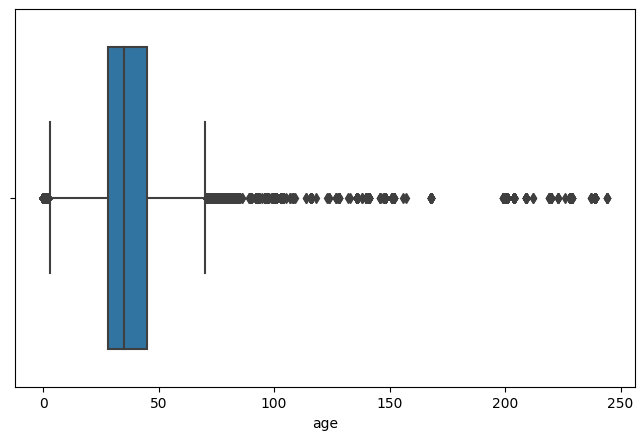

In [37]:
sns.boxplot(merged_df['age'])

In [38]:
# Outlier data became NaN
merged_df.loc[(merged_df.age > 90) | (merged_df.age < 10)] = np.nan

In [39]:
missing_values(merged_df['age'])

Count of missing values is 
285733
------------------------------
Percentage of missng values is 
27.71050569469013


In [40]:
# Null values in age column
nulls = sum(merged_df['age'].isnull())

In [41]:
# Imputing null values
median = merged_df['age'].median()
std = merged_df['age'].std()

# Fill invalid and missing ages with random normal distributed numbers
random_age = np.random.randint(median - std, median + std, size = nulls)
age = merged_df['age'].copy()
age[pd.isnull(age)] = random_age
merged_df['age'] = age
merged_df['age'] = merged_df['age'].astype(int)

In [42]:
missing_values(merged_df['age'])

Count of missing values is 
0
------------------------------
Percentage of missng values is 
0.0


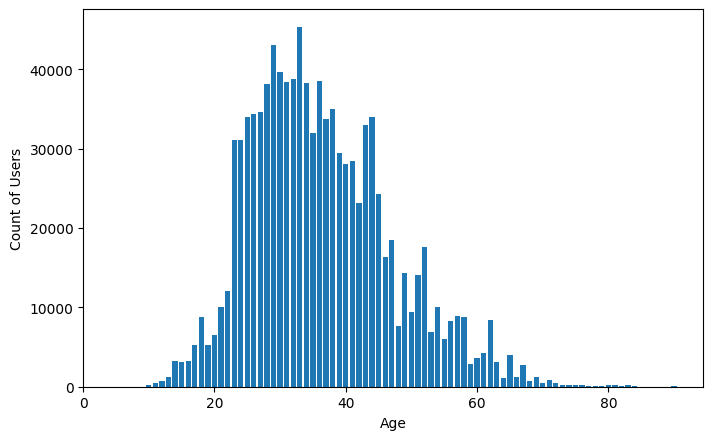

In [43]:
u = merged_df.age.value_counts().sort_index()
plt.bar(u.index, u.values)
plt.xlabel('Age')
plt.ylabel('Count of Users')
plt.xlim(xmin = 0)
plt.show()

It's observable that **maximum** number of users were of age in between **20 to 45**. 

Text(0.5, 1.0, 'Top 10 authors with most number of books published')

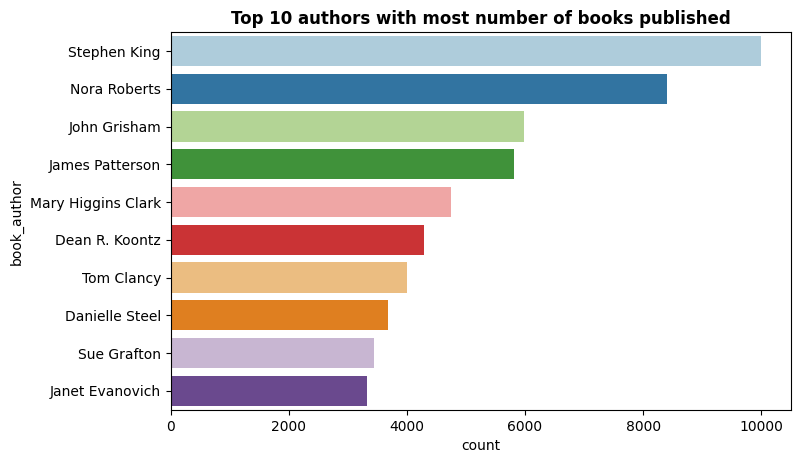

In [44]:
sns.countplot(y="book_author",palette = 'Paired', data=merged_df,order=merged_df['book_author'].value_counts().index[:10])
plt.title("Top 10 authors with most number of books published", fontweight='bold')

Text(0.5, 1.0, 'Top 10 Publishers')

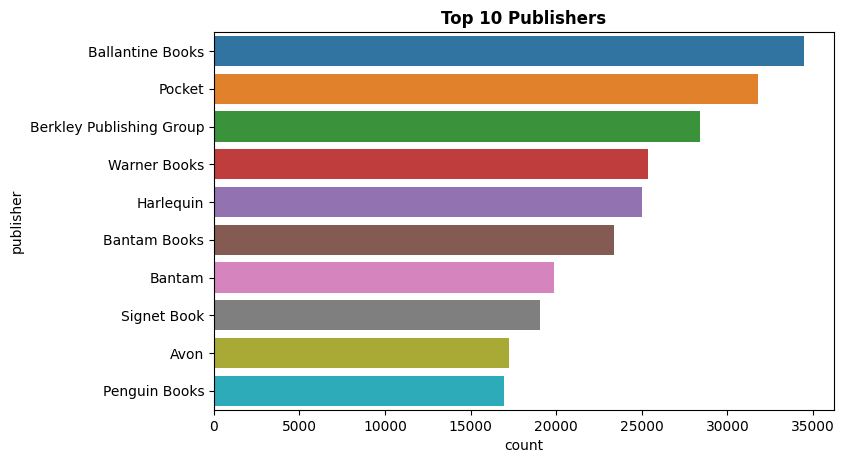

In [45]:
sns.countplot(y='publisher',data=merged_df,order=pd.value_counts(merged_df['publisher']).iloc[:10].index)
plt.title('Top 10 Publishers', fontweight='bold')

Text(0.5, 1.0, 'Top 5 countries')

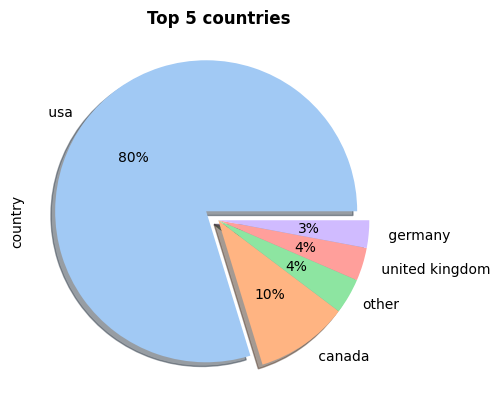

In [46]:
palette_color = sns.color_palette('pastel')
explode = (0.1, 0, 0, 0, 0)
merged_df.country.value_counts().iloc[:5].plot(kind='pie', colors=palette_color, autopct='%.0f%%', explode=explode, shadow=True)
plt.title('Top 5 countries', fontweight='bold')

Most of the **ratings** given were from **USA** followed by **Canada**.

In [47]:
merged_df[merged_df['year_of_publication']!=0]['year_of_publication'].value_counts()

2002.0    91221
2001.0    79285
1999.0    74644
2003.0    72057
2000.0    71808
          ...  
2008.0    1    
2012.0    1    
1378.0    1    
1897.0    1    
2024.0    1    
Name: year_of_publication, Length: 115, dtype: int64

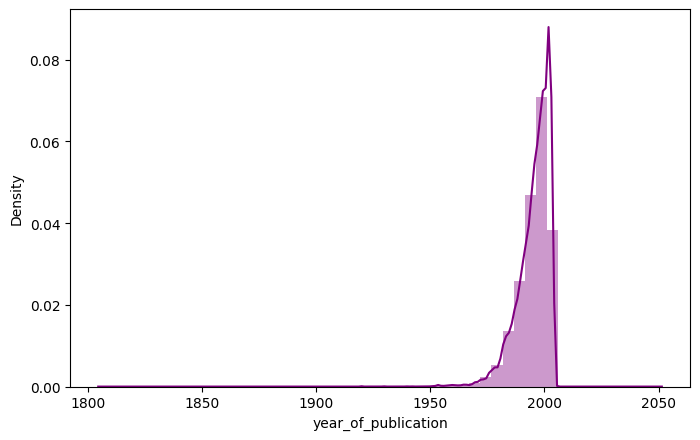

In [48]:
sns.distplot(merged_df[merged_df['year_of_publication']>1800]['year_of_publication'],color='purple',bins=50)

There was an exponential increase in **book publication** after the year **1950**.

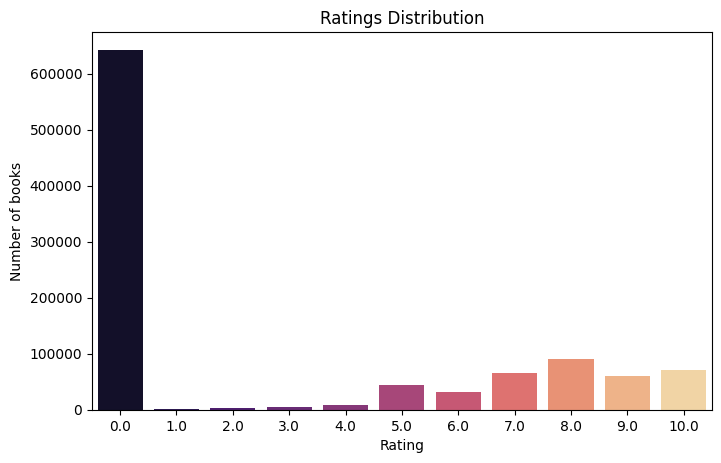

In [50]:
sns.barplot(x = merged_df['book_rating'].value_counts().index,y = merged_df['book_rating'].value_counts().values,
            palette = 'magma').set(title="Ratings Distribution", xlabel = "Rating",ylabel = 'Number of books')
plt.show()

Text(0.5, 1.0, 'Explicit Ratings')

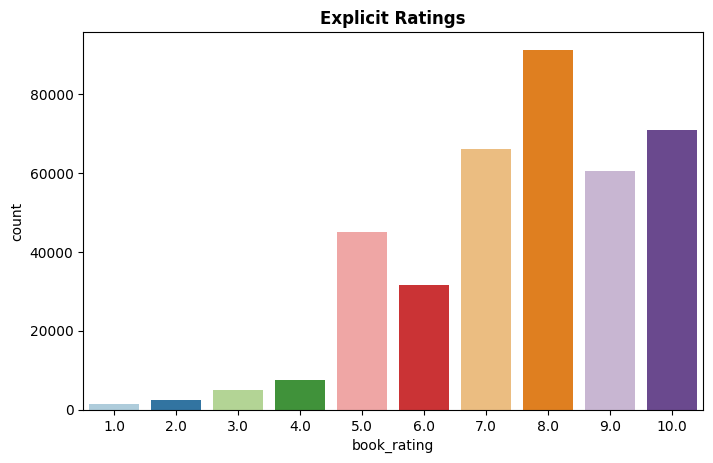

In [51]:
# Explicit Ratings
explicit_ratings_df = merged_df[merged_df['book_rating'] != 0]
sns.countplot(x="book_rating",palette = 'Paired',data=explicit_ratings_df)
plt.title("Explicit Ratings", fontweight='bold')

Text(0.5, 1.0, 'Top 10 most rated books')

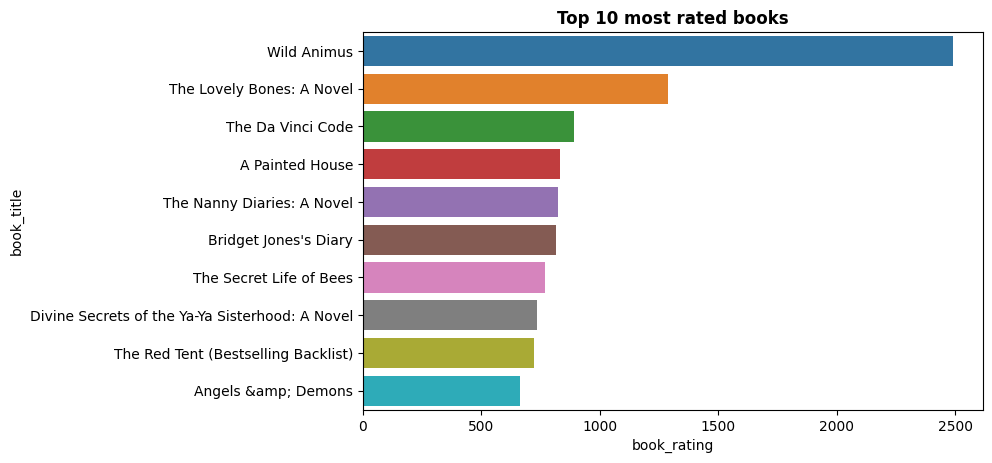

In [52]:
#Book ratings count using group by
book_rating = merged_df.groupby(['book_title'])['book_rating'].count().sort_values(ascending=False).reset_index()

sns.barplot(book_rating['book_rating'][:10],book_rating['book_title'][:10])
plt.title('Top 10 most rated books', fontweight='bold')

In [53]:
# Consider only explicit ratings
merged_df = merged_df[merged_df['book_rating']!=0]

# Create column average ratings
merged_df['avg_Rating'] = merged_df.groupby('isbn')['book_rating'].transform('mean')

# Create column sum of users
merged_df['total_no_of_users'] = merged_df.groupby('isbn')['book_rating'].transform('count')

In [54]:
merged_df.head()

,user_id,age,isbn,book_rating,book_title,book_author,year_of_publication,publisher,country,avg_Rating,total_no_of_users
1,8.0,44,0002005018,5.0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,canada,7.666667,9.0
3,11676.0,30,0002005018,8.0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,other,7.666667,9.0
5,67544.0,30,0002005018,8.0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,canada,7.666667,9.0
8,116866.0,29,0002005018,9.0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,other,7.666667,9.0
9,123629.0,33,0002005018,9.0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,canada,7.666667,9.0


In [55]:
merged_df.shape

(389237, 11)

In [56]:
missing_values(merged_df)

Count of missing values is 
user_id                7898
age                    0   
isbn                   7898
book_rating            7898
book_title             7898
book_author            7898
year_of_publication    7898
publisher              7898
country                7898
avg_Rating             7898
total_no_of_users      7898
dtype: int64
------------------------------
Percentage of missng values is 
user_id                2.029098
age                    0.000000
isbn                   2.029098
book_rating            2.029098
book_title             2.029098
book_author            2.029098
year_of_publication    2.029098
publisher              2.029098
country                2.029098
avg_Rating             2.029098
total_no_of_users      2.029098
dtype: float64
